Why should you choose this project and not OpenAI GPT model(s) ?
- Built cost-effective model using open-source Llama V2 for efficient inference in every query.
- Utilized open-source model to create embeddings, reducing costs for knowledge base from PDFs, regardless of size.
- Eliminated expenses for future embedding creation, avoiding dependence on changing OpenAI models.
- Avoided high-computational, costly methods like Graph Knowledge or Reinforcement Learning.
- Avoided time-consuming and expensive fine-tuning of the model.
Ensured data security by not sharing PDF data with external companies like OpenAI.
- Hosted the model on a private cloud, preventing third-party access.
Achieved efficient and simplified approach for streamlined debugging.

In [ ]:
!nvidia-smi

Mon Aug 28 09:47:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

In [ ]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Fetched 186 kB in 1s (257 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 120831 

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


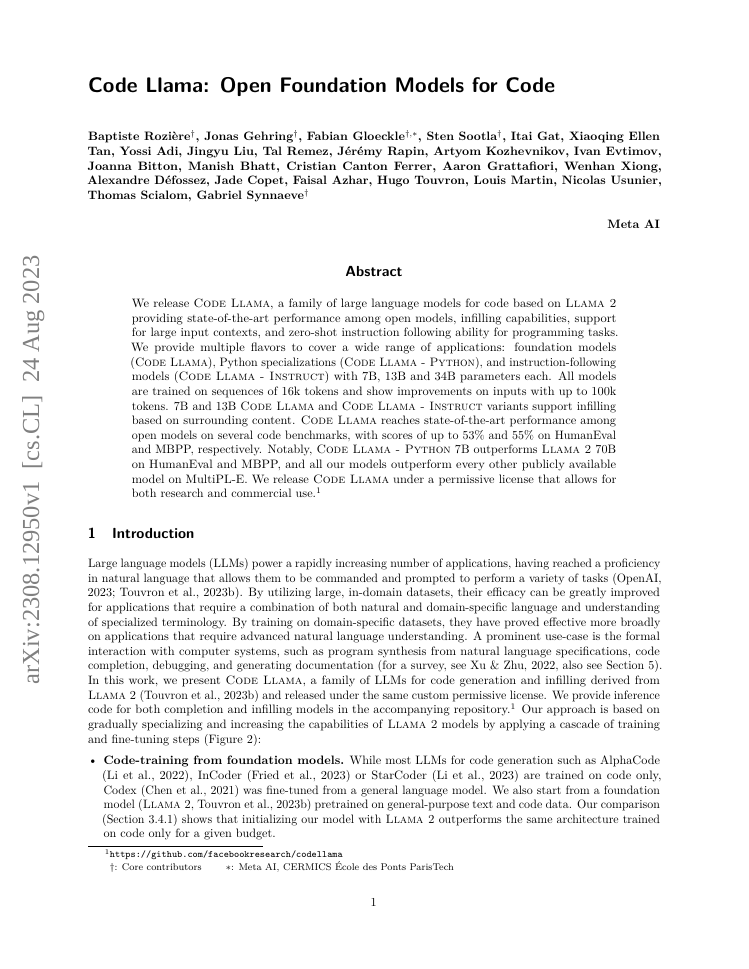

In [ ]:
#meta_images = convert_from_path("pdfs/meta-earnings-report.pdf", dpi=88)
meta_images = convert_from_path("/content/drive/MyDrive/pdfs/Code-Llama-Open-Foundation-Models-for-Code.pdf", dpi=88)
meta_images[0]


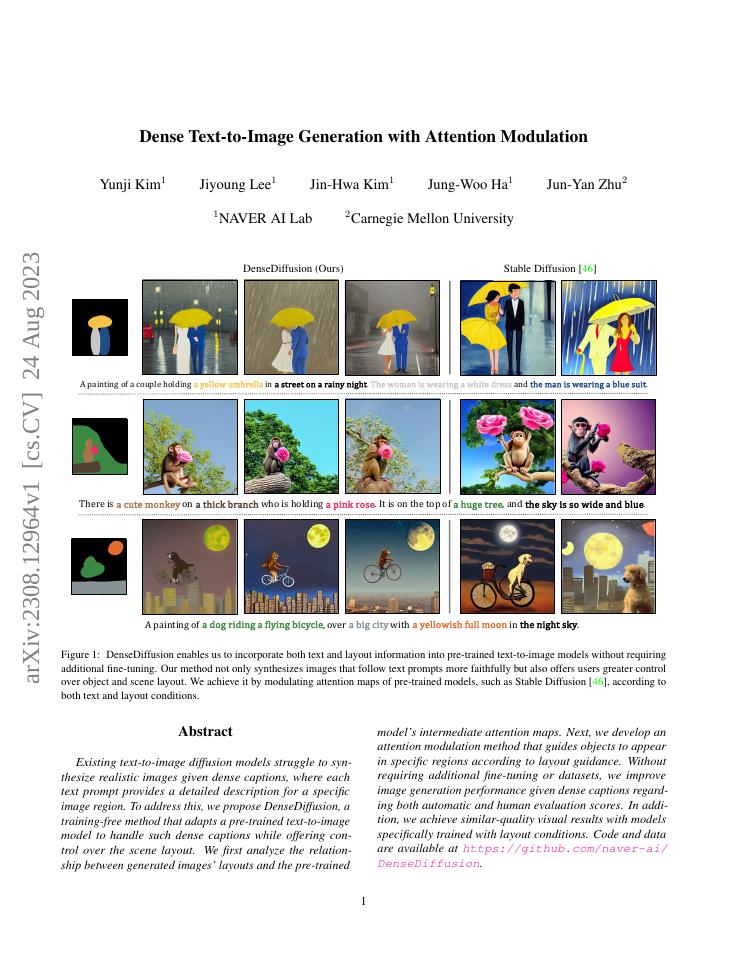

In [ ]:
#nvidia_images = convert_from_path("pdfs/nvidia-earnings-report.pdf", dpi=88)
nvidia_images = convert_from_path("/content/drive/MyDrive/pdfs/Dense Text-to-Image Generation with Attention Modulation.pdf", dpi=88)
nvidia_images[0]

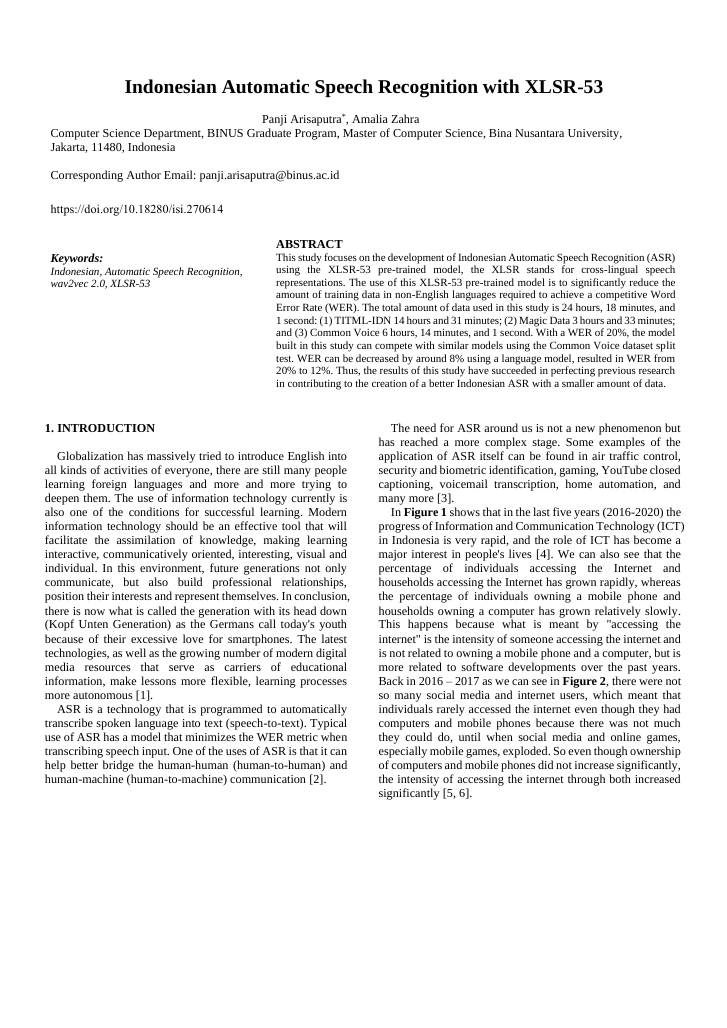

In [ ]:
#tesla_images = convert_from_path("pdfs/tesla-earnings-report.pdf", dpi=88)
tesla_images = convert_from_path("/content/drive/MyDrive/pdfs/Indonesian Automatic Speech Recognition with XLSR-53.pdf", dpi=88)
tesla_images[0]

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("/content/drive/MyDrive/pdfs")
docs = loader.load()
len(docs)

76

In [ ]:
"""embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)
"""

embeddings = HuggingFaceInstructEmbeddings(
    model_name="BAAI/bge-large-en", model_kwargs={"device": DEVICE}
)


load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

294

In [ ]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 26 s, sys: 1.59 s, total: 27.6 s
Wall time: 37.4 s


## Llama 2 13B

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

In [ ]:
!nvidia-smi

Mon Aug 28 10:15:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   9695MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} [/INST]
""".strip()

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

In [ ]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausal

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})

In [ ]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

## Chat with Multiple PDFs

In [ ]:
result = qa_chain("Can you tell me about Code Llama?")

 Sure! Based on the information provided in the text, here's what I can tell you about Code Llama:

Code Llama is a language model that was trained from scratch using a large corpus of text data. The model was trained for 240 billion tokens, which is a significant amount of training data. According to the text, the model has a high level of performance, with a loss equal to the loss of Code Llama 7B at about half of its training. Additionally, the text states that Code Llama improves its performance over time.

However, the text does not provide any specific information about the capabilities or features of Code Llama beyond its performance on a particular task. Therefore, I cannot provide more detailed information about the model's functionality or how it compares to other language models.


In [ ]:
print(result["source_documents"][0].page_content)

using ```:
{PROMPT}
A:
Figure 13: Prompts used to evaluate Code Llama on APPS.
34


In [ ]:
print(result["source_documents"][1].page_content)

(Figure 5b). At the end of training, the loss of the model trained from scratch is equal to the loss of
Code Llama 7B at about half of its training (with 240B less training tokens). Moreover, this gap becomes
larger over time.
3.4.2 Instruction fine-tuning
General helpfulness vs. coding ability We evaluate Code Llama - Instruct and compare it to
Llama 2 -Chat for coding tasks and helpfulness (Figure 5c). We observe that Code Llama improves its
12


In [ ]:
result = qa_chain("What is Dense Text-to-Image Generation with Attention Modulation?")

 Based on the given context, I can answer the question as follows:

Dense Text-to-Image Generation with Attention Modulation is a method proposed by Yunji Kim et al. in their research paper titled "DenseDiffusion: Dense Text-to-Image Generation with Attention Modulation". This method aims to improve the quality of text-to-image synthesis by incorporating both text and layout information into pre-trained text-to-image models without requiring additional fine-tuning. The approach involves modulating the attention maps of pre-trained models, such as Stable Diffusion, according to both textual and layout information. The authors claim that this method offers users greater control over object and scene layout and can generate more diverse and accurate images compared to existing methods.


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

Dense Text-to-Image Generation with Attention Modulation
Yunji Kim1Jiyoung Lee1Jin-Hwa Kim1Jung-Woo Ha1Jun-Yan Zhu2
1NA VER AI Lab2Carnegie Mellon University
DenseDiffusion (Ours) Stable Diffusion [46]
There	is	a	cute	monkey	on	a	thick	branch	who	is	holding	a	pink	rose.	It	is	on	the	top	of	a	huge	tree,	and	the	sky	is	so	wide	and	blue.
A	painting	of	a	couple	holding	a	yellow	umbrellain	a	street	on	a	rainy	night.	The	woman	is	wearing	a	white	dressand	the	man	is	wearing	a	blue	suit.
A	painting	of	a	dog	riding	a	flying	bicycle,	over	a	big	city	with	a	yellowish	full	moonin	the	night	sky.
Figure 1: DenseDiffusion enables us to incorporate both text and layout information into pre-trained text-to-image models without requiring
additional fine-tuning. Our method not only synthesizes images that follow text prompts more faithfully but also offers users greater control
over object and scene layout. We achieve it by modulating attention maps of pre-trained models, such as Stable Diffusion [ 46], 

In [ ]:
result = qa_chain("What is Indonesian Automatic Speech Recognition with XLSR-53?")

 Based on the provided abstract, Indonesian Automatic Speech Recognition with XLSR-53 refers to a research study that focuses on developing an automatic speech recognition system for the Indonesian language using the XLSR-53 pre-trained model. The XLSR-53 model is a cross-lingual speech representation model that can be used to recognize speech in various languages, including Indonesian. The study aimed to evaluate the effectiveness of using the XLSR-53 model in recognizing Indonesian speech and compared its performance with a previous model called wav2vec 2.0. The study found that the XLSR-53 model outperformed the wav2vec 2.0 model in recognizing Indonesian speech, even with less data.


In [ ]:
print(result["source_documents"][0].page_content)

Indonesian Automatic Speech Recognition with XLSR -53 
 
Panji Arisaputra*, Amalia Zahra   
Computer Science Department, BINUS Graduate Program, Master of Computer Science, Bina Nusantara University, 
Jakarta, 11480, Indonesia   
 
Corresponding Author Email:  panji.arisaputra@binus.ac.id   
 
https://doi.org/10.18280/isi.270614 
   
ABSTRACT  
Keywords:  
Indonesian, Automatic Speech Recognition, 
wav2vec 2.0, XLSR -53  This study focuses on the development of Indonesian Automatic Speech Recognition (ASR) 
using the  XLSR -53 pre -trained model , the XLSR stands for cross -lingual speech 
representations . The use of this XLSR -53 pre -trained model is to significantly reduce the 
amount of training data in non -English languages required to achieve a competitive Word 
Error Rate (WER) . The total amount of data used in this study is 24 hours, 18 minutes, and 
1 second: (1) TITML -IDN 14 hours and 31 minutes; (2) Magic Data 3 hours and 33 minutes;


In [ ]:
result = qa_chain("What is Dense Text-to-Image Generation with Attention Modulation and Indonesian Automatic Speech Recognition with XLSR-53?")

 Based on the provided context, I can answer the following questions:

What is Dense Text-to-Image Generation with Attention Modulation?

Dense Text-to-Image Generation with Attention Modulation is a method that incorporates both text and layout information into pre-trained text-to-image models without requiring additional fine-tuning. It modulates the attention maps of pre-trained models, such as Stable Diffusion [46], to synthesize images that follow text prompts more faithfully and offer users greater control over object and scene layout.

What is Indonesian Automatic Speech Recognition with XLSR-53?

Indonesian Automatic Speech Recognition with XLSR-53 is a study that focuses on developing an automatic speech recognition system for Indonesian language using the pre-trained XLSR-53 model. The XLSR stands for cross-lingual speech representations, which aims to significantly reduce the amount of training data required to achieve a competitive word error rate in non-English languages.


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

Indonesian Automatic Speech Recognition with XLSR -53 
 
Panji Arisaputra*, Amalia Zahra   
Computer Science Department, BINUS Graduate Program, Master of Computer Science, Bina Nusantara University, 
Jakarta, 11480, Indonesia   
 
Corresponding Author Email:  panji.arisaputra@binus.ac.id   
 
https://doi.org/10.18280/isi.270614 
   
ABSTRACT  
Keywords:  
Indonesian, Automatic Speech Recognition, 
wav2vec 2.0, XLSR -53  This study focuses on the development of Indonesian Automatic Speech Recognition (ASR) 
using the  XLSR -53 pre -trained model , the XLSR stands for cross -lingual speech 
representations . The use of this XLSR -53 pre -trained model is to significantly reduce the 
amount of training data in non -English languages required to achieve a competitive Word 
Error Rate (WER) . The total amount of data used in this study is 24 hours, 18 minutes, and 
1 second: (1) TITML -IDN 14 hours and 31 minutes; (2) Magic Data 3 hours and 33 minutes;


In [ ]:
print(result["source_documents"][1].page_content)

Dense Text-to-Image Generation with Attention Modulation
Yunji Kim1Jiyoung Lee1Jin-Hwa Kim1Jung-Woo Ha1Jun-Yan Zhu2
1NA VER AI Lab2Carnegie Mellon University
DenseDiffusion (Ours) Stable Diffusion [46]
There	is	a	cute	monkey	on	a	thick	branch	who	is	holding	a	pink	rose.	It	is	on	the	top	of	a	huge	tree,	and	the	sky	is	so	wide	and	blue.
A	painting	of	a	couple	holding	a	yellow	umbrellain	a	street	on	a	rainy	night.	The	woman	is	wearing	a	white	dressand	the	man	is	wearing	a	blue	suit.
A	painting	of	a	dog	riding	a	flying	bicycle,	over	a	big	city	with	a	yellowish	full	moonin	the	night	sky.
Figure 1: DenseDiffusion enables us to incorporate both text and layout information into pre-trained text-to-image models without requiring
additional fine-tuning. Our method not only synthesizes images that follow text prompts more faithfully but also offers users greater control
over object and scene layout. We achieve it by modulating attention maps of pre-trained models, such as Stable Diffusion [ 46], 

In [ ]:
result = qa_chain("What is Dense Text-to-Image Generation with Attention Modulation and Indonesian Automatic Speech Recognition with XLSR-53?")

 Based on the provided context, I can answer the following questions:

What is Dense Text-to-Image Generation with Attention Modulation?

Dense Text-to-Image Generation with Attention Modulation is a method that incorporates both text and layout information into pre-trained text-to-image models without requiring additional fine-tuning. It modulates the attention maps of pre-trained models, such as Stable Diffusion [46], to synthesize images that follow text prompts more faithfully and offer users greater control over object and scene layout.

What is Indonesian Automatic Speech Recognition with XLSR-53?

Indonesian Automatic Speech Recognition with XLSR-53 is a study that focuses on developing an automatic speech recognition system for Indonesian language using the pre-trained XLSR-53 model. The XLSR stands for cross-lingual speech representations, which aims to significantly reduce the amount of training data required to achieve a competitive word error rate in non-English languages.


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

Indonesian Automatic Speech Recognition with XLSR -53 
 
Panji Arisaputra*, Amalia Zahra   
Computer Science Department, BINUS Graduate Program, Master of Computer Science, Bina Nusantara University, 
Jakarta, 11480, Indonesia   
 
Corresponding Author Email:  panji.arisaputra@binus.ac.id   
 
https://doi.org/10.18280/isi.270614 
   
ABSTRACT  
Keywords:  
Indonesian, Automatic Speech Recognition, 
wav2vec 2.0, XLSR -53  This study focuses on the development of Indonesian Automatic Speech Recognition (ASR) 
using the  XLSR -53 pre -trained model , the XLSR stands for cross -lingual speech 
representations . The use of this XLSR -53 pre -trained model is to significantly reduce the 
amount of training data in non -English languages required to achieve a competitive Word 
Error Rate (WER) . The total amount of data used in this study is 24 hours, 18 minutes, and 
1 second: (1) TITML -IDN 14 hours and 31 minutes; (2) Magic Data 3 hours and 33 minutes;


In [ ]:
print(result["source_documents"][1].page_content)

Dense Text-to-Image Generation with Attention Modulation
Yunji Kim1Jiyoung Lee1Jin-Hwa Kim1Jung-Woo Ha1Jun-Yan Zhu2
1NA VER AI Lab2Carnegie Mellon University
DenseDiffusion (Ours) Stable Diffusion [46]
There	is	a	cute	monkey	on	a	thick	branch	who	is	holding	a	pink	rose.	It	is	on	the	top	of	a	huge	tree,	and	the	sky	is	so	wide	and	blue.
A	painting	of	a	couple	holding	a	yellow	umbrellain	a	street	on	a	rainy	night.	The	woman	is	wearing	a	white	dressand	the	man	is	wearing	a	blue	suit.
A	painting	of	a	dog	riding	a	flying	bicycle,	over	a	big	city	with	a	yellowish	full	moonin	the	night	sky.
Figure 1: DenseDiffusion enables us to incorporate both text and layout information into pre-trained text-to-image models without requiring
additional fine-tuning. Our method not only synthesizes images that follow text prompts more faithfully but also offers users greater control
over object and scene layout. We achieve it by modulating attention maps of pre-trained models, such as Stable Diffusion [ 46], 

In [ ]:
result = qa_chain("Can you explain about Long context fine-tuning?")

 Based on the given context, I can explain Long Context Fine-Tuning (LCFT) as follows:

Long Context Fine-Tuning is a technique used in the paper to improve the performance of the Code Llama models on code completion tasks. It involves fine-tuning the models on longer sequences, specifically those with more than 4,000 tokens, to leverage the information in these long contexts to improve the generation of code completions. The authors found that long contexts are informative for code completion and that LCFT allows the models to better utilize this information.

The authors used a learning rate of 2e-5 for LCFT and observed that it slightly hurt the performance on standard code synthesis benchmarks consisting of short sequences. However, the improvement in performance on long sequences outweighed the slight decrease in performance on short sequences. Specifically, the authors observed an average decrease of 0.52 percentage points on HumanEval pass@1 and 1.9 points on MBPP for the pass@1

In [ ]:
print(result["source_documents"][0].page_content)

(6%) and our natural language dataset (2%).
2.6 Training details
Optimization. Our optimizer is AdamW (Loshchilov & Hutter, 2019) with β1andβ2values of 0.9 and
0.95. We use a cosine schedule with 1000warm-up steps, and set the final learning rate to be 1/30th of the
peak learning rate. We use a batch size of 4M tokens which are presented as sequences of 4,096 tokens each.
Despite the standard practice of using lower learning rates in fine-tuning stages than in pre-training stages,
we obtained best results when retaining the original learning rate of the Llama 2 base model. We carry
these findings to the 13B and 34B models, and set their learning rates to 3e−4and1.5e−4, respectively. For
python fine-tuning, we set the initial learning rate to 1e−4instead. For Code Llama - Instruct , we train
with a batch size of 524,288 tokens and on approx. 5B tokens in total.
Long context fine-tuning. For long context fine-tuning (LCFT), we use a learning rate of 2e−5, a sequence


In [ ]:
print(result["source_documents"][1].page_content)

long contexts are informative for code completion, and that with LCFT our models are able to leverage this
information to improve their generations. We note that the longest example’s prompt in this test consists
of 103K tokens, for which all Code Llama models generate syntactically correct completions, with the 7B
model producing an exact match.
Performance impact on short contexts. While our models are effective on long sequences, we observe
that LCFT slightly hurts performance on standard code synthesis benchmarks consisting of short sequences.
In Table 10, we observe an average decrease of 0.52 percentage points on HumanEval pass@1 and 1.9 points
on MBPP for the pass@1 metric. Similarly, a breakdown of the code completion results in Table 7 by the
number of tokens in each example shows that for prompts shorter than 4k tokens, long context fine-tuning
induces a reduction of up to 2 BLEU points from base models after code training (Figure 8b). We observe


In [ ]:
result = qa_chain("What is Long context fine-tuning? ")

 Based on the given context, I can answer the question.

Long context fine-tuning refers to a specific fine-tuning method used for the LLaMA models, particularly Code Llama, to enable it to operate on very large contexts (up to 100,000 tokens) beyond the standard 4,096 tokens supported by the model. This is achieved by modifying the parameters of the RoPE positional embeddings used in the model. The goal of long context fine-tuning is to improve the model's performance on standard coding benchmarks while maintaining a moderate impact on its overall performance.


In [ ]:
print(result["source_documents"][0].page_content)

(6%) and our natural language dataset (2%).
2.6 Training details
Optimization. Our optimizer is AdamW (Loshchilov & Hutter, 2019) with β1andβ2values of 0.9 and
0.95. We use a cosine schedule with 1000warm-up steps, and set the final learning rate to be 1/30th of the
peak learning rate. We use a batch size of 4M tokens which are presented as sequences of 4,096 tokens each.
Despite the standard practice of using lower learning rates in fine-tuning stages than in pre-training stages,
we obtained best results when retaining the original learning rate of the Llama 2 base model. We carry
these findings to the 13B and 34B models, and set their learning rates to 3e−4and1.5e−4, respectively. For
python fine-tuning, we set the initial learning rate to 1e−4instead. For Code Llama - Instruct , we train
with a batch size of 524,288 tokens and on approx. 5B tokens in total.
Long context fine-tuning. For long context fine-tuning (LCFT), we use a learning rate of 2e−5, a sequence


In [ ]:
print(result["source_documents"][1].page_content)

to function-level or file-level – requires prompting the model with much longer context than the 4,096
tokens supported by Llama 2 . We propose an additional fine-tuning stage that extends the maximum
context length from 4,096 tokens to 100,000 tokens by modifying the parameters of the RoPE positional
embeddings (Su et al., 2021) used in Llama 2 . Our experiments show Code Llama operating on very
large contexts with a moderate impact on performances on standard coding benchmarks (Section 3.3).
•Instruction fine-tuning. For end-users, the utility of LLMs is significantly improved by instruction
fine-tuning (Ouyang et al., 2022; Wei et al., 2022; OpenAI, 2023; Touvron et al., 2023b), which also helps
preventing unsafe, toxic or biased generations. Code Llama - Instruct variants are further fine-tuned
on a mix of proprietary instruction data for improved safety and helpfulness, and a new machine-generated
self-instruct dataset created by prompting Llama 2 for coding problems and Code Llam

In [ ]:
result = qa_chain("What is Long context fine-tuning with context to code Llama model and do you know about Text-to-Image Diffusion Models? ")

 Based on the provided context, here are my answers to your questions:

1. What is Long context fine-tuning with context to code Llama model?

Long context fine-tuning with context to code Llama model refers to the process of training the Code Llama language model to handle longer contexts beyond its original training data. This involves fine-tuning the model on a larger dataset that includes longer sequences of text, such as entire files or documents, rather than just individual lines or sentences. By doing so, the model can learn to generate more accurate and relevant completions for longer sequences of code.

2. Do you know about Text-to-Image Diffusion Models?

No, I don't have information about Text-to-Image Diffusion Models. The provided context only discusses the Code Llama language model and its fine-tuning for long contexts. There is no mention of Text-to-Image Diffusion Models.


In [ ]:
result = qa_chain("What is Long context fine-tuning with context to code Llama model? Another question is do you know about Text-to-Image Diffusion Models?")

 Based on the provided context, here are my answers to your questions:

1. What is Long context fine-tuning with context to code Llama model?

Long context fine-tuning with context to code Llama model refers to a process of fine-tuning the Code Llama language model to handle longer contexts, specifically in the context of code completion tasks. The model is trained on a dataset of code examples, and the goal is to improve its ability to generate accurate and relevant code completions for given prompts, even when the context is longer than what the model has seen before.

2. Do you know about Text-to-Image Diffusion Models?

No, I don't have information about Text-to-Image Diffusion Models. The provided context does not mention this term, and I am not aware of any specific models or techniques with this name.
